In [1]:
import numpy as np
from math import sqrt, cos, sin, ceil
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm

In [2]:
# Globals

# Estimation params for UKF
# Predicted state covariance
# [variance on x-axis, variance on y-axis, yaw variance, velocity variance]
Q = np.diag([0.1, 0.1, np.deg2rad(1.0), 1.0]) ** 2
# observation x, y position covariance
R = np.diag([1.0, 1.0]) ** 2

#  Sim params
gps_noise = np.diag([0.5, 0.5])**2
input_noise = np.diag([1.0, np.deg2rad(30.0)])**2

dt = 0.1
sim_time = 50.0

#  UKF params
ALPHA = 0.001
BETA = 2
KAPPA = 0

show_animation = True

In [3]:
def u(v=1.0, yaw=0.1):
    """
    Devolve o vetor de entrada
    num dado instante.
    """
    return np.array([[v, yaw]]).T

In [4]:
def mm(x, u, dt=0.1):
    """
    Devolve o valor de x[t+1]
    de acordo com o modelo dinâmico
    definido na ficha 4:
    xt = F * xt + B * ut
    """
    F = np.identity(4, dtype=float)
    F[3, 3] = 0
    B = np.array([[dt * cos(x[2, 0]), 0],
                  [dt * sin(x[2, 0]), 0],
                  [0.0, dt],
                  [1.0, 0.0]])

    return F.dot(x) + B.dot(u)

In [5]:
def jH():
    """
    Devolve a matriz jacobiana do modelo de
    observação da ficha 4.
    """
    return np.identity(4)[0:2]

In [6]:
def om(x):
    """
    Devolve o modelo de observação
    de acordo com o enunciado da ficha 4:
    zt = H * xt
    """
    return jH().dot(x)

In [7]:
def observation(x, xdr, u):
    x = mm(x, u)

    # add noise to gps x-y
    z = om(x) + gps_noise.dot(np.random.randn(2, 1))

    # add noise to input
    ud = u + input_noise.dot(np.random.randn(2, 1))

    xdr = mm(xdr, ud)

    return x, z, xdr, ud

In [8]:
def genSigmaPoints(x, p, gamma):
    """
    Gera pontos sigma usando:
    a) x, p (ambos valores estimados
    pelo modelo dinâmico) e gamma;
    """
    x0 = x
    return np.concatenate((
        x0,
        x0 - gamma * sqrtm(p),
        x0 + gamma * sqrtm(p)
    ), axis=1)
    

In [9]:
def predSigmaMotion(sigma, u):
    """
    Previsão de pontos sigma através do
    modelo dinâmico.
    """
    return mm(sigma, u)

In [10]:
def predSigmaObservation(sigma):
    """
    Previsão de pontos sigma através do
    modelo de observação.
    """
    return om(sigma)

In [11]:
def calcSigmaCov(x, sigma, wP, pi):
    return wP * (sigma - x) @ (sigma - x).T + pi

In [12]:
def calcPxz(sigma, x, zsigma, zb, wP):
    return wP * (sigma - x) @ (zsigma - zb).T

In [13]:
def ukf(x, p, z, u, wm, wP, gamma):
    # Predict (UKF - time update)
    # Calculate the sigma-points using xExt (xhat_k|k) and PEst (P_k|k)
    # and gamma in def generate_sigma_points
    sigma = genSigmaPoints(x, p, gamma)
    
    # Propagate the sigma-points (x^(i)_k+1|k = f(x^(i)_k|k , w^(i)_k)) 
    # using the sigma-points obtained in the previous calculus and u (ud = noisy u)
    # in def predict_sigma_motion
    sigma_prop = predSigmaMotion(sigma, u)

    # Calculate xPred (xhat_k+1|k) using wm and the propagated sigma-points 
    xpred = wm @ sigma_prop.T
    xpred = xpred.T

    # Calculate PPred (P_k|k-1) using xPred, the propagated sigma-points
    # wc and Q in def calc_sigma_covariance
    ppred = calcSigmaCov(xpred, sigma_prop, wP, Q)

    #  Update (UKF - measurement update)
    # Calculate zPred (yhat_t) using xPred (xhat_k+1|k) in def observation_model
    zpred = om(xpred)

    # Calculate y = (y_t - yhat_t) using z (y_t) and zPred (yhat_t)
    y = z - zpred
    
    # Calculate the sigma-points using xPred (xhat_k|k-1), PPred (P_k|k-1)
    # and gamma in def generate_sigma_points
    sigma = genSigmaPoints(xpred, ppred, gamma)
    
    # Propagate the sigma-points z_sigma (y^(i)_t = h(x^(i)_t|t-1 , e^(i)_t)) 
    # using the propagated sigma-points in def predict_sigma_observation
    z_sigma = predSigmaObservation(sigma)

    # Calculate zb (yhat_t) using wm and the sigma-points y^(i)_t 
    zb = wm @ z_sigma.T
    zb = zb.T
    
    # Calculate the sigma covariance, st (P^yy_t|t-1), using zb (yhat_t),
    # z_sigma (y^(i)_t), wc and R in def calc_sigma_covariance
    st = calcSigmaCov(zb, z_sigma, wP, R.T)
    
    # Calculate Pxz (P^xy_t|t-1) using sigma (x^(i)_t|t-1), xPred (xhat_t|t-1),
    # z_sigma (y^(i)_t), zb (yhat_t) and wc in def calc_pxz
    pxz = calcPxz(sigma, xpred, z_sigma, zb, wP)
    
    # Calculate K_t using Pxz (P^xy_t|t-1) and st (P^yy_t|t-1)
    Kt = pxz @ np.linalg.inv(st.astype(float))
    
    # Update xEst (Xhat_t|t) using xPred (xhat_t|t-1), K_t and y (y_t - yhat_t)
    x = xpred + Kt @ y
    
    # Update PEst (P_t|t) using PPred (P_t|t-1), K_t and st (P^yy_t|t-1)
    p = ppred - Kt @ st @ Kt.T

    return x, p

In [14]:
def initWeights(L):
    # lambda
    lamb = ALPHA ** 2 * (L + KAPPA) - L

    # w^(0)_m and w^(0)_P
    wm = [lamb / (lamb + L)]
    wP = [(lamb / (lamb + L)) + (1 - ALPHA ** 2 + BETA)]

    # w^(+-j)_m = w^(+-j)_P
    const = 1.0 / (2 * (L + lamb))
    for j in range(2 * L):
        wm.append(const)
        wP.append(const)
    
    gamma = sqrt(L + lamb)

    return np.array([wm]), np.array([wP]), gamma

In [15]:
def save(hxpred, xpred, hxdr, xdr, hxtrue, xtrue, hz, z):
    hxpred = np.hstack((hxpred, xpred))
    hxtrue = np.hstack((hxtrue, xtrue))
    hxdr = np.hstack((hxdr, xdr))
    hz = np.vstack((hz, z))
    return hxpred, hxtrue, hxdr, hz

In [16]:
def main():
    print('Robot sim initiated!')
    L = 4
    xpred = np.zeros((L, 1))
    xtrue = np.zeros((L, 1))
    ppred = np.eye(L)
    wm, wP, gamma = initWeights(L)
    xdr = np.zeros((L, 1))

    # history 
    hxpred = xpred
    hxtrue = xtrue
    hxdr = xdr
    hz = np.zeros((2, 1))

    time = 0.0

    fig = plt.figure()
    fig.show()

    while time <= sim_time:
        time += dt

        xtrue, z, xdr, ud = observation(xtrue, xdr, u())
        xpred, ppred = ukf(xpred, ppred, z, ud, wm, wP, gamma)
        # hxpred, hxdr, hxtrue, hz = save(hxpred, xpred, hxdr, xdr, hxtrue, xtrue, hz, z)
        hxpred = np.hstack((hxpred, xpred))
        hxdr = np.hstack((hxdr, xdr))
        hxtrue = np.hstack((hxtrue, xtrue))
        hz = np.vstack((hz, z))

    plt.cla()
    plt.plot(hz[0, :], hz[1, :], ".g")
    plt.plot(hxtrue[0, :].flatten(), hxtrue[1, :].flatten(), "-b")
    plt.plot(hxdr[0, :].flatten(), hxdr[1, :].flatten(), "-k")
    plt.plot(hxpred[0, :].flatten(), hxpred[1, :].flatten(), "-r")
    plt.axis("equal")
    plt.grid(True)

        # gif
        # filename = f'{int(ceil(time * 10))}.jpeg'
        # plt.savefig(filename)
        
    plt.pause(0.001)

Robot sim initiated!


C:\Users\MANUEL~1\AppData\Local\Temp/ipykernel_3244/4057142730.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


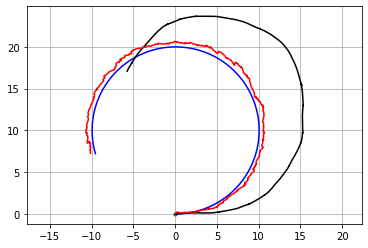

In [17]:
main()